In [1]:
!git clone https://github.com/BecerraMiguel/tokamak-fno.git
%cd tokamak-fno

Cloning into 'tokamak-fno'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 4), reused 25 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 927.17 KiB | 4.39 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/tokamak-fno


In [7]:
import os

# Ajusta esta ruta según donde tengas tu archivo
DATA_PATH = '/content/tokamak_synthetic_1000.h5'

# O si lo tienes en otra ubicación:
# DATA_PATH = "/content/tokamak-fno/data/tokamak_synthetic_1000.h5"

if os.path.exists(DATA_PATH):
    print(f"✓ Archivo encontrado: {DATA_PATH}")
    print(f"  Tamaño: {os.path.getsize(DATA_PATH) / 1024 / 1024:.2f} MB")
else:
    print(f"✗ Archivo NO encontrado: {DATA_PATH}")
    print("  Verifica la ruta correcta")

✓ Archivo encontrado: /content/tokamak_synthetic_1000.h5
  Tamaño: 16.43 MB


In [8]:
import sys

# Si clonaste el repo:
sys.path.insert(0, '/content/tokamak-fno')

# O si subiste los archivos manualmente, ajusta según tu estructura

In [9]:
from src.data.loader import get_dataloaders, print_dataset_info

# Crear los DataLoaders
print("Cargando datos y creando DataLoaders...")
train_loader, val_loader, info = get_dataloaders(
    h5_path=DATA_PATH,
    batch_size=32,
    val_split=0.2,
    seed=42
)

# Mostrar información del dataset
print_dataset_info(info)

Cargando datos y creando DataLoaders...
INFORMACIÓN DEL DATASET

Muestras de entrenamiento: 800
Muestras de validación:    200
Canales (señales):         5
Pasos temporales:          1000

Distribución de clases (Train):
  - Normal:     400
  - Disruptivo: 400

Distribución de clases (Validation):
  - Normal:     100
  - Disruptivo: 100


In [10]:
print("\n" + "="*50)
print("VERIFICACIÓN DE SHAPES")
print("="*50)

# Obtener un batch de entrenamiento
for signals, labels in train_loader:
    print(f"\nBatch de entrenamiento:")
    print(f"  Signals shape: {signals.shape}")
    print(f"  Labels shape:  {labels.shape}")
    print(f"  Signals dtype: {signals.dtype}")
    print(f"  Labels dtype:  {labels.dtype}")
    break

# Obtener un batch de validación
for signals, labels in val_loader:
    print(f"\nBatch de validación:")
    print(f"  Signals shape: {signals.shape}")
    print(f"  Labels shape:  {labels.shape}")
    break

print("\n✓ Shapes correctas: [batch_size, n_channels, time_steps]")


VERIFICACIÓN DE SHAPES

Batch de entrenamiento:
  Signals shape: torch.Size([32, 5, 1000])
  Labels shape:  torch.Size([32])
  Signals dtype: torch.float32
  Labels dtype:  torch.int64

Batch de validación:
  Signals shape: torch.Size([32, 5, 1000])
  Labels shape:  torch.Size([32])

✓ Shapes correctas: [batch_size, n_channels, time_steps]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [11]:
import torch

print("\n" + "="*50)
print("VERIFICACIÓN DE NORMALIZACIÓN")
print("="*50)

# Recolectar estadísticas de todo el train set
all_signals = []
for signals, labels in train_loader:
    all_signals.append(signals)

all_signals = torch.cat(all_signals, dim=0)
print(f"\nTotal de muestras en train: {all_signals.shape[0]}")

# Calcular media y std por canal
channel_names = ['Ip', 'βN', 'q95', 'ne', 'li']

print("\nEstadísticas por canal (después de normalización):")
print("-" * 45)
print(f"{'Canal':<10} {'Media':>12} {'Std':>12}")
print("-" * 45)

for i, name in enumerate(channel_names):
    channel_data = all_signals[:, i, :]
    mean = channel_data.mean().item()
    std = channel_data.std().item()
    print(f"{name:<10} {mean:>12.4f} {std:>12.4f}")

print("-" * 45)
print("\n✓ Si la normalización es correcta:")
print("  - Las medias deben estar cercanas a 0")
print("  - Las std deben estar cercanas a 1")


VERIFICACIÓN DE NORMALIZACIÓN

Total de muestras en train: 800

Estadísticas por canal (después de normalización):
---------------------------------------------
Canal             Media          Std
---------------------------------------------
Ip               0.0000       1.0000
βN              -0.0000       1.0000
q95              0.0000       1.0000
ne              -0.0000       1.0000
li              -0.0000       1.0000
---------------------------------------------

✓ Si la normalización es correcta:
  - Las medias deben estar cercanas a 0
  - Las std deben estar cercanas a 1


In [12]:
print("\n" + "="*50)
print("VERIFICACIÓN DE REPRODUCIBILIDAD")
print("="*50)

# Crear DataLoaders dos veces con la misma semilla
_, _, info1 = get_dataloaders(DATA_PATH, seed=42)
_, _, info2 = get_dataloaders(DATA_PATH, seed=42)

# Comparar distribuciones
match = (info1['train_class_distribution'] == info2['train_class_distribution'] and
         info1['val_class_distribution'] == info2['val_class_distribution'])

if match:
    print("\n✓ Reproducibilidad verificada!")
    print("  Misma semilla = mismo split de datos")
else:
    print("\n✗ ERROR: Los splits no son reproducibles")

# Probar con semilla diferente
_, _, info3 = get_dataloaders(DATA_PATH, seed=123)
different = (info1['train_class_distribution'] != info3['train_class_distribution'])

if different:
    print("✓ Semillas diferentes producen splits diferentes (esperado)")


VERIFICACIÓN DE REPRODUCIBILIDAD

✓ Reproducibilidad verificada!
  Misma semilla = mismo split de datos


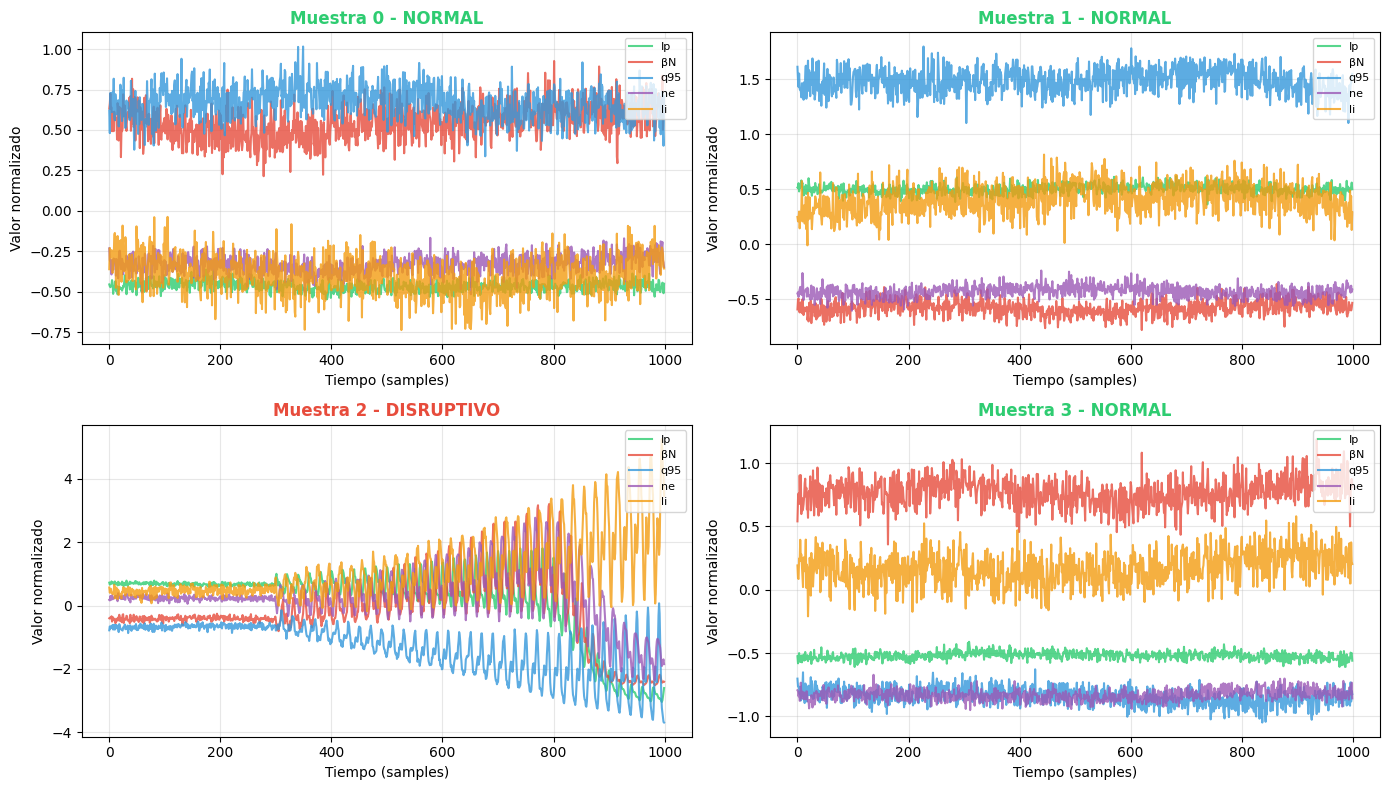


✓ Visualización guardada como 'batch_visualization.png'


In [14]:
import matplotlib.pyplot as plt

# Obtener un batch
for signals, labels in train_loader:
    break

# Seleccionar 4 muestras (2 normales, 2 disruptivas si es posible)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
channel_names = ['Ip', 'βN', 'q95', 'ne', 'li']
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12']

for idx, ax in enumerate(axes.flat):
    if idx >= len(signals):
        break

    signal = signals[idx].numpy()
    label = labels[idx].item()
    label_text = "DISRUPTIVO" if label == 1 else "NORMAL"
    color = '#e74c3c' if label == 1 else '#2ecc71'

    for ch in range(signal.shape[0]):
        ax.plot(signal[ch], label=channel_names[ch], color=colors[ch], alpha=0.8)

    ax.set_title(f'Muestra {idx} - {label_text}', fontsize=12, color=color, fontweight='bold')
    ax.set_xlabel('Tiempo (samples)')
    ax.set_ylabel('Valor normalizado')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('batch_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualización guardada como 'batch_visualization.png'")
